# Prediction

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mixtape-Sessions/Machine-Learning/blob/main/Labs/python/Prediction.ipynb)

Outcome to be predicted: $Y_i$
> *example:* a worker's log wage

Characteristics (aka **features**): $X_i=\left(X_{1i},\ldots,X_{pi}\right)'$
> *example:* education, age, state of birth, parents' education, cognitive ability, family background


In [2]:
%matplotlib inline

# import some useful packages
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split


plt.style.use('seaborn-whitegrid')

# read in data
nlsy=pd.read_csv('https://github.com/Mixtape-Sessions/Machine-Learning/blob/main/Labs/data/nlsy97.csv?raw=true')
nlsy

,lnw_2016,educ,black,hispanic,other,exp,afqt,mom_educ,dad_educ,yhea_100_1997,...,_XPexp_13,_XPexp_14,_XPexp_16,_XPexp_17,_XPexp_18,_XPexp_19,_XPexp_20,_XPexp_21,_XPexp_22,_XPexp_23
0,4.076898,16,0,0,0,11,7.0724,12,12,3,...,0,0,0,0,0,0,0,0,0,0
1,3.294138,9,0,0,0,19,4.7481,9,10,2,...,0,0,0,0,0,1,0,0,0,0
2,2.830896,9,0,1,0,22,1.1987,12,9,3,...,0,0,0,0,0,0,0,0,1,0
3,4.306459,16,0,0,0,13,8.9321,16,18,2,...,1,0,0,0,0,0,0,0,0,0
4,5.991465,16,0,1,0,15,2.2618,16,16,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1261,1.833475,14,1,0,0,17,3.8179,15,12,2,...,0,0,0,1,0,0,0,0,0,0
1262,3.341985,9,0,1,0,20,3.3043,12,11,2,...,0,0,0,0,0,0,1,0,0,0
1263,-0.928125,10,1,0,0,19,1.0319,10,13,2,...,0,0,0,0,0,1,0,0,0,0
1264,3.702931,18,0,0,0,12,8.5093,16,19,2,...,0,0,0,0,0,0,0,0,0,0


## Least squares benchmark

In [3]:
# generate dictionary of transformations of education
powerlist=[nlsy['educ']**j for j in np.arange(1,10)] # ten times square of education level
X=pd.concat(powerlist,axis=1)
X.columns = ['educ'+str(j) for j in np.arange(1,10)]
# standardize our X matrix (doesn't matter for OLS, but will matter for lasso below)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# run least squares regression
# instantiate and fite our regression object:
reg=linear_model.LinearRegression().fit(X_scaled,nlsy['lnw_2016'])
# generate predicted values
yhat=reg.predict(X_scaled)

In [5]:
# plot predicted values
lnwbar=nlsy.groupby('educ')['lnw_2016'].mean() # log of wage rate by education group
Xbar=pd.DataFrame({'educ':lnwbar.index.values})
powerlist=[Xbar['educ']**j for j in np.arange(1,10)]
Xbar=pd.concat(powerlist,axis=1)
Xbar.columns = X.columns
Xbar_scaled = scaler.transform(Xbar)
ybarhat=reg.predict(Xbar_scaled)
fig = plt.figure()
ax = plt.axes()
ax.plot(Xbar['educ1'],lnwbar,'bo',Xbar['educ1'],ybarhat,'g-');
plt.title("ln Wages by Education in the NLSY")
plt.xlabel("years of schooling")
plt.ylabel("ln wages");

    educ1  educ2  educ3   educ4    educ5     educ6       educ7        educ8  \
0       8     64    512    4096    32768    262144     2097152     16777216   
1       9     81    729    6561    59049    531441     4782969     43046721   
2      10    100   1000   10000   100000   1000000    10000000    100000000   
3      11    121   1331   14641   161051   1771561    19487171    214358881   
4      12    144   1728   20736   248832   2985984    35831808    429981696   
5      13    169   2197   28561   371293   4826809    62748517    815730721   
6      14    196   2744   38416   537824   7529536   105413504   1475789056   
7      15    225   3375   50625   759375  11390625   170859375   2562890625   
8      16    256   4096   65536  1048576  16777216   268435456   4294967296   
9      17    289   4913   83521  1419857  24137569   410338673   6975757441   
10     18    324   5832  104976  1889568  34012224   612220032  11019960576   
11     19    361   6859  130321  2476099  47045881  

As we can see, least squares linear regression can approximate any continuous function and can certainly be used for prediction. Include a rich enough set of transformations, and OLS predictions will yield unbiased estimates of the true ideal predictor, the conditional expectation function. But these estimates will be quite noisy. Penalized regression can greatly reduce the variance, at the expense of some bias. But if the bias reduction is great enough, the predictions can have lower MSE. Back to the whiteboard!


## Lasso in action

Welcome back! Let's see lasso in action:

In [11]:
# fit lasso with a couple of different alphas and plot results
# instantiate and fite our lasso object
lasso1 = linear_model.Lasso(alpha=.001,max_iter=1000).fit(X_scaled,nlsy['lnw_2016'])
print(lasso1.get_params()) # this stors a bunch of parameters that is used in Lasso regression
print(lasso1.coef_) # this stors the coefficients of features that is kept
#generate predicted values
ybarhat1=lasso1.predict(Xbar_scaled)

# same thing but with a different alpha
lasso2 = linear_model.Lasso(alpha=.01,max_iter=1000).fit(X_scaled,nlsy['lnw_2016'])
ybarhat2=lasso2.predict(Xbar_scaled)

{'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
[ 0.          0.13799397  0.16661037  0.          0.          0.
 -0.         -0.         -0.0951063 ]


Plot results

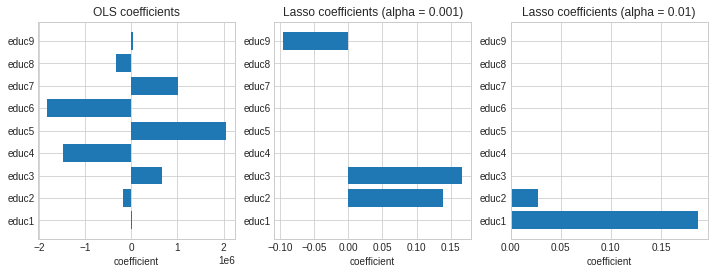

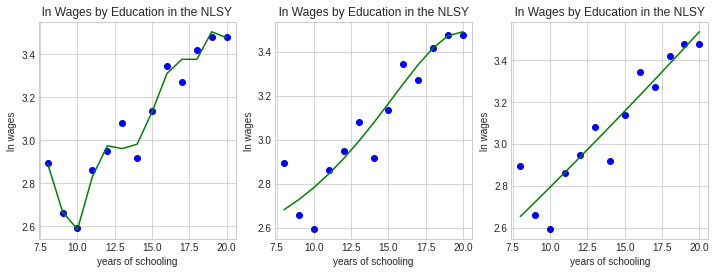

In [12]:
#@title
fig1,(ax11,ax12,ax13) = plt.subplots(1,3,figsize=(12, 4))
ax11.barh(Xbar.columns,reg.coef_,align='center');
ax11.set_title("OLS coefficients")
ax11.set_xlabel("coefficient")
ax12.barh(Xbar.columns,lasso1.coef_,align='center');
ax12.set_title("Lasso coefficients (alpha = {:.3f})".format(lasso1.get_params()['alpha']))
ax12.set_xlabel("coefficient")
ax13.barh(Xbar.columns,lasso2.coef_,align='center');
ax13.set_title("Lasso coefficients (alpha = {:.2f})".format(lasso2.get_params()['alpha']))
ax13.set_xlabel("coefficient")
fig2,(ax21,ax22,ax23) = plt.subplots(1,3,figsize=(12,4))
ax21.plot(Xbar['educ1'],lnwbar,'bo',Xbar['educ1'],ybarhat,'g-');
ax21.set_title("ln Wages by Education in the NLSY")
ax21.set_xlabel("years of schooling")
ax21.set_ylabel("ln wages");
ax22.plot(Xbar['educ1'],lnwbar,'bo',Xbar['educ1'],ybarhat1,'g-');
ax22.set_title("ln Wages by Education in the NLSY")
ax22.set_xlabel("years of schooling")
ax22.set_ylabel("ln wages");
ax23.plot(Xbar['educ1'],lnwbar,'bo',Xbar['educ1'],ybarhat2,'g-');
ax23.set_title("ln Wages by Education in the NLSY")
ax23.set_xlabel("years of schooling")
ax23.set_ylabel("ln wages");

Play around with different values for alpha to see how the fit changes!

### Data-driven tuning parameters: Cross-validation

Quick trip back to the whiteboard!

In [14]:
# define grid for alpha
alpha_grid = {'alpha': [.0001,.001,.002, .004, .006, .008, .01, .012, .014, .016 ,.018, .02 ],'max_iter': [100000]}
# instantiate and fit our gridsearchcv object
grid_search = GridSearchCV(linear_model.Lasso(),alpha_grid,cv=5,return_train_score=True).fit(X_scaled,nlsy['lnw_2016'])
# print out the chosen value for alpha
print("Best alpha: ",grid_search.best_estimator_.get_params()['alpha'])

Best alpha:  0.014


### Lasso-guided variable selection
For illustrative purposes we've been using lasso to determine the functional form for a single underlying regressor: education. But lasso's real power comes in selecting among a large number of regressors.

In [26]:
# Define "menu" of regressors:
X=nlsy.drop(columns=['lnw_2016','exp'])

# Divide into training and test set so we can honestly gauge predictive accuracy
X_train, X_test, y_train, y_test = train_test_split(X, nlsy['lnw_2016'],random_state=42) # By default, 75% will be train
# Scale regressors
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Do cross-validated Lasso (the easy way!)
# instantiate and fit our lassocv object
lassocv=linear_model.LassoCV(random_state=42, cv=5).fit(X_train_scaled,y_train)
# print out the chosen value for alpha
print("Chosen alpha: {:.3f}".format(lassocv.alpha_))
# print the original number of regressors and the number selected by lasso
print("Number of regressors in the menu: ",len(X.columns))
print("Number of regressors selected by lasso: ",sum(lassocv.coef_!=0))
# print out accuracy on training and test test
print("Accuracy on training set: {:.3f}".format(lassocv.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(lassocv.score(X_test_scaled,y_test)))
# look at the coefficients
results = pd.DataFrame({'feature': X.columns[lassocv.coef_!=0],'coefficient': lassocv.coef_[lassocv.coef_!=0]})
results

KeyboardInterrupt: ignored

To try on your own: load the Oregon HIE data from earlier and try lassoing the OLS regression we did there. What do you notice?


In [16]:
# Load Oregon HIE data . . .

## Ridge regression
First, whiteboard. Ridge is another flavor of penalized regression, like lasso. But unlike lasso, ridge penalizes the squares (not the absolute values) of the coefficients. As a result, ridge shrinks coefficients toward zero, but not all the way. Let's give it a try.

In [24]:
# Try it on your own first with the NLSY data! (Hint: instead of LassoCV, use RidgeCV(cv=5), and it doesn't let you set random_state. 
# Also, don't forget to define your X and y variables if you re-defined them with the Oregon HIE data)

# Define "menu" of regressors:
X=nlsy.drop(columns=['lnw_2016','exp'])

# Divide into training and test set so we can honestly gauge predictive accuracy
X_train, X_test, y_train, y_test = train_test_split(X, nlsy['lnw_2016'],random_state=42) # By default, 75% will be train
# Scale regressors
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# instantiate and fit your ridge object
ridgecv=linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5).fit(X_train_scaled,y_train)
# print out the chosen value for alpha
print("Chosen alpha: {:.3f}".format(ridgecv.alpha_))
# print the original number of regressors and the number selected by lasso
print("Number of regressors in the menu: ",len(X.columns))
print("Number of regressors selected by ridge regression: ",sum(ridgecv.coef_!=0))
# print out accuracy on training and test test
print("Accuracy on training set: {:.3f}".format(ridgecv.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(ridgecv.score(X_test_scaled,y_test)))
# look at the coefficients
results = pd.DataFrame({'feature': X.columns[ridgecv.coef_!=0],'coefficient': ridgecv.coef_[ridgecv.coef_!=0]})
results
# print accuracy on training set and test set

# inspect the coefficients


Chosen alpha: 1.000
Number of regressors in the menu:  992
Number of regressors selected by lasso:  912
Accuracy on training set: 0.755
Accuracy on test set: -2.748


,feature,coefficient
0,educ,-0.154568
1,black,0.015065
2,hispanic,0.128092
3,other,-0.023078
4,afqt,0.094838
...,...,...
907,_XPexp_19,-0.032415
908,_XPexp_20,-0.078016
909,_XPexp_21,-0.038253
910,_XPexp_22,-0.060542


### Cheat

In [ ]:
ridgecv=linear_model.RidgeCV(cv=5,alphas=(.1,1,10,50,100,1000)).fit(X_train_scaled,y_train)
print("Chosen alpha: {:.3f}".format(ridgecv.alpha_))
print("Accuracy on training set: {:.3f}".format(ridgecv.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(ridgecv.score(X_test_scaled,y_test)))
# look at the coefficients
results = pd.DataFrame({'feature': X.columns[ridgecv.coef_!=0],'coefficient': ridgecv.coef_[ridgecv.coef_!=0]})
results

### ...
What do we learn about the relative performance of Lasso and Ridge in this setting? What could be the explanation?

One way to compare Lasso and Ridge, is to visualize their coefficients:

NameError: ignored

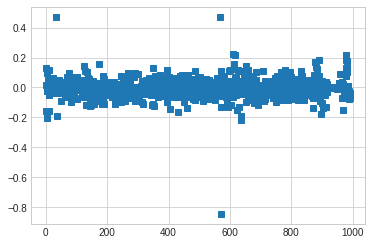

In [25]:
plt.plot(ridgecv.coef_, 's', label="RidgeCV")
plt.plot(lassocv.coef_, 'o', label="LassoCV")
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.legend()

## Elastic Net: best of both worlds?
Elastic net combines lasso and ridge penalization. First, a bit of whiteboard, then let's give it a try.

In [ ]:
# Try it yourself first!

# instantiate and fit your elasticnetcv object (hint: it's linear_model.ElasticNetCV,
# and supply it a grid for the l1 ratio: l1_ratio=[.1, .5, .7, .9, .95, .99, 1]

# print out the chosen l1 ratio and alpha

# print out the original and selected number of regressors

# print out accuracy in the training and test set

# look at the coefficients




### Cheat

In [ ]:
encv=linear_model.ElasticNetCV(random_state=42,l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(X_train_scaled,y_train)
print("Chosen l1 ratio: {:.3f}".format(encv.l1_ratio_))
print("Chosen alpha: {:.3f}".format(encv.alpha_))
print("Number of regressors in the menu: ",len(X.columns))
print("Number of regressors selected by elastic net: ",sum(encv.coef_!=0))
print("Accuracy on training set: {:.3f}".format(encv.score(X_train_scaled,y_train)))
print("Accuracy on test set: {:.3f}".format(encv.score(X_test_scaled,y_test)))
# look at the coefficients
results = pd.DataFrame({'feature': X.columns[encv.coef_!=0],'coefficient': encv.coef_[encv.coef_!=0]})
results

### ...
Not surprisingly, it doesn't look terribly different from lasso.

## Decision Trees and Random Forests
First, a trip to the whiteboard

Import some utilities:

In [28]:
#@title
import requests
url1 = 'https://www.dropbox.com/s/jgml061manxpawo/plot_2d_separator.py?raw=true'
url2 = 'https://www.dropbox.com/s/hlrrlwm4kt36awb/plot_interactive_tree.py?raw=true'
url3 = 'https://www.dropbox.com/s/e2cy203sr30a59z/plot_helpers.py?raw=true'
url4 = 'https://www.dropbox.com/s/aik5sgcwgz4brwn/tools.py?raw=true'
r1 = requests.get(url1)
r2 = requests.get(url2)
r3 = requests.get(url3)
r4 = requests.get(url4)

# make sure your filename is the same as how you want to import 
with open('plot_2d_separator.py', 'w') as f1:
    f1.write(r1.text)

with open('plot_interactive_tree.py', 'w') as f2:
    f2.write(r2.text)

with open('plot_helpers.py', 'w') as f3:
    f3.write(r3.text)

with open('tools.py', 'w') as f4:
    f4.write(r4.text)

# now we can import
import plot_helpers
import tools
import plot_2d_separator
import plot_interactive_tree

Let's illustrate how random forests average over a collection of individual trees:

[[ 1.87756309  0.56839425]
 [ 0.36877983 -0.34894509]
 [ 0.96515318  0.10921819]
 [ 0.48599685  0.20291313]
 [ 1.72532644  0.53367598]
 [ 1.47976586  0.08726406]
 [ 2.11889248  0.60498388]
 [-0.74017805  0.49615542]
 [-0.38099245  1.34740194]
 [ 0.22944941  0.87981305]
 [ 1.31311917 -0.69665985]
 [ 0.87435391  0.83750547]
 [ 0.77145295 -0.69709227]
 [ 1.26285558  0.12916271]
 [-0.71988634  0.69106791]
 [ 0.79205253 -0.40516241]
 [ 1.31886119 -0.41396289]
 [ 0.26579093  0.78151982]
 [ 0.08686038  0.49400243]
 [-0.74872343 -0.06972957]
 [ 0.88404174 -0.35425773]
 [ 1.02671711  0.73292915]
 [ 0.73867317  0.30808589]
 [ 1.12856036  0.33191968]
 [ 1.15536561 -0.50593577]
 [ 1.56825139 -0.05911358]
 [ 0.29004812  1.00820293]
 [ 0.64076308 -0.19860992]
 [-1.20034998  0.46412528]
 [-0.16955317  0.60660877]
 [-0.53369875  0.50244086]
 [ 1.00549331  0.38686701]
 [ 0.65294065  0.80929512]
 [-0.56688607  0.73004641]
 [ 1.71942343  0.32909081]
 [ 0.96514959  0.51823046]
 [ 0.2683596  -0.11030872]
 

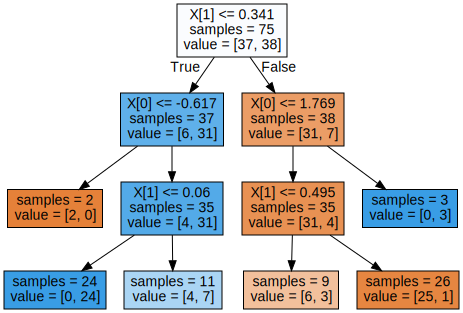

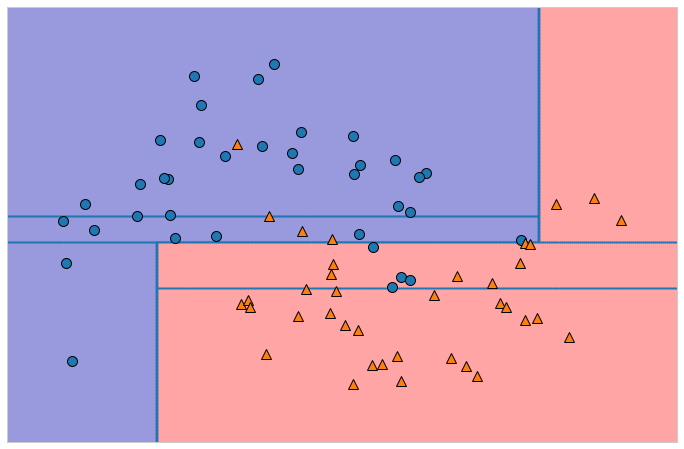

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.datasets import make_moons

Xfake, yfake = make_moons(n_samples=100, noise=0.25, random_state=3)
print(Xfake)
Xfake_train, Xfake_test, yfake_train, yfake_test = train_test_split(Xfake, yfake, stratify=yfake,
                                                    random_state=42)

#First a simple tree:
tree = DecisionTreeClassifier(max_depth=3).fit(Xfake_train,yfake_train)
fig1,ax = plt.subplots(1,1,figsize=(12, 8))
plot_interactive_tree.plot_tree_partition(Xfake_train, yfake_train, tree, ax=ax)
dot_data= export_graphviz(tree, out_file=None, impurity=False, filled=True)
graph = graphviz.Source(dot_data) 
graph

We got trees down. Now to the whiteboard to talk about random forests

In [ ]:
# Now average over several trees:

forest = RandomForestClassifier(n_estimators=5, random_state=2).fit(Xfake_train, yfake_train)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    plot_interactive_tree.plot_tree_partition(Xfake_train, yfake_train, tree, ax=ax)
    
plot_2d_separator.plot_2d_separator(forest, Xfake_train, fill=True, ax=axes[-1, -1],
                                alpha=.4)
axes[-1, -1].set_title("Random Forest")
plot_helpers.discrete_scatter(Xfake_train[:, 0], Xfake_train[:, 1], yfake_train)

Enough with fake data. Let's use random forests to predict wages in the NLSY, just as we did for Lasso, Ridge, and Elastic net. Try it on your own! Hint: we want RandomForestRegressor, not RandomForestClassifier. For bonus points, cross-validate random forest's tuning parameters using GridSearchCV.

In [ ]:
# Try it on your own!

# Import the proper package

# instantiate your random forest object and fit it

# print out training set and test set accuracy

### Cheat

In [30]:
from sklearn.ensemble import RandomForestRegressor

# First without cross-validating
rf=RandomForestRegressor(random_state=42).fit(X_train,y_train)
print("Accuracy on training set: {:.3f}".format(rf.score(X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(rf.score(X_test,y_test)))

Accuracy on training set: 0.872
Accuracy on test set: 0.101


In [31]:
# Now with cross-validation
# define grid for max_depth
param_grid = {'max_depth': [5,10,100]}
grid_searchrf = GridSearchCV(RandomForestRegressor(),param_grid,cv=5,return_train_score=True).fit(X_train,y_train)
print("Best max_depth: ",grid_searchrf.best_estimator_.get_params()['max_depth'])
print("Accuracy on training set: {:.3f}".format(grid_searchrf.score(X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(grid_searchrf.score(X_test,y_test)))

# why did cv estimator perform badly than non-CV result

Best max_depth:  5
Accuracy on training set: 0.353
Accuracy on test set: 0.098


How does Random Forest compare with Lasso?